<a href="https://colab.research.google.com/github/zanthony42/carFleetSimulation/blob/main/4201_Car_Fleet_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Philip DeMeyer pjd0074
#Anthony Zuniga az0162
import networkx as nx
import matplotlib.pyplot as plt
import random as rd
MAXINT = 10000

In [ ]:
vehicleList = []
SEED = 1000   # seed , for reproducibility
NODES = 200   # graph nodes

CONNECT = .05 #.05 = 2, .07 = 4
NUM_VEHICLES = 30

G= nx.gnp_random_graph (NODES, CONNECT, seed=SEED )     #random binomial graph

edges = sorted(nx.k_edge_augmentation(G,4))
for i in edges:
  G.add_edges_from(edges)
print(nx.edge_connectivity(G))

4


In [ ]:
def printNodes():
  print("Nodes:", G.nodes())

def printEdges():
  print("Edges:", G.edges())

def printAdjList():       #function for printing adjacency list
  print("Adjacency List:")
  for line in nx.generate_adjlist(G):
      print(line)

In [ ]:
def printGraph():
  SEED = 1000
  pos = nx.spring_layout(G, seed=SEED)  
  nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G), \
      node_size=1200, node_color='orange', linewidths=0.25, \
      font_size=10, font_weight='bold', with_labels=True)
  plt.show()

In [ ]:
def generateRideRequest():  # generates random ride request with different start and end values
  nodeStart = rd.randint(0,NODES-1)
  nodeEnd = rd.randint(0,NODES-1)
  while (nodeStart == nodeEnd): #makes sure drop off node does not equal pick up node
    nodeEnd = rd.randint(0,NODES-1)
  return nodeStart, nodeEnd

In [ ]:
# Vehicles are stored in a list (vehicleList). Each entry in the list is a dictionary entry (vehicle) containing vehicle information.
def initVehicles(numVehicles):  #initialize vehicle locations and id #NOTE: Multiple vehicles may be initialized to the same location
  vehicleList.clear()
  rd.seed(10000)
  for i in range(0,numVehicles):
    temp = rd.randint(0,NODES-1)
    vehicle = { "id" : i+1, "currentNode" : temp, "passArrived": 0, "destNodes": [], "passengers": 0, "distTraveled": 0}
    vehicleList.append(vehicle)

def printVehicleList():
  print(*vehicleList,  sep= "\n")

In [ ]:
def getVElement(id, key): # finds data of a certain vehicle, key is vehicle property
  for i in vehicleList:
    if i["id"] == id:
      elem = i[key]
      return elem

def setVElement(id, key, data): # updates data of a certain vehicle
  for i in vehicleList:
    if i["id"] == id:
      if key == "destNodes":#clears before assigning the data
        i["destNodes"].clear
        i["destNodes"] = data
      else:
        i[key] = data
  return 0

In [ ]:
def findClosestVehicle(nodeReq): #finds closest vehicle to specified node, returns vehicle id and distance of path
  # initialize temporary to extreme values
  closestId = 0 #getVElement(1,"id")
  closestLen = MAXINT #nx.shortest_path_length(G,nodeReq, getVElement(1,"currentNode"))
  # check through vehicleList and find a closer vehicle
  for i in vehicleList:
    nodeVeh = i["currentNode"]
    vehPassengers = i["passengers"]
    if vehPassengers >= 5:
      continue
    else:
      length = nx.shortest_path_length(G,nodeReq, nodeVeh)
      if length <= closestLen:
        closestLen = length
        closestId = i["id"]
  return closestId, closestLen

def assignVehicle(id, destNode): #assigns passenger to specified vehicle if it is not full
  numPassengers = getVElement(id, "passengers")
  if numPassengers < 5:
    setVElement(id, "passengers", (numPassengers+1)) #increase passenger count
    destNodeArray = getVElement(id, "destNodes")
    if bool(destNodeArray):
      destNodeArray.append(destNode)
      setVElement(id, "destNodes", destNodeArray) #append destination node if others exist
    else:
      array = []
      array.append(destNode)
      setVElement(id, "destNodes", array)
    return 0
  else:
    print("All vehicles are full, request failed")
    return 1

def assignRide(rideReq): #assigns passenger to closest available vehicle
  closestVeh = findClosestVehicle(rideReq[0])
  assignVehicle(closestVeh[0],rideReq)
  return closestVeh

In [ ]:
def findClosestDestinationPath(id): #determines which destination node is closest to the vehicle and gives the path
  array = getVElement(id,"destNodes")
  currentNode = getVElement(id,"currentNode")
  if bool(array):
    #print(array[0],"before")
    min = nx.shortest_path_length(G, currentNode, array[0][0])
    #print(array[0],"after")
    path = nx.shortest_path(G, currentNode, array[0][0])
    for i in array:
      temp = nx.shortest_path_length(G, currentNode, i[0])
      if min > temp:
        min = temp
        path = nx.shortest_path(G, currentNode, i[0])
    return path

In [ ]:
def moveVehicles(): #moves all the vehicles
  for i in range(1,NUM_VEHICLES+1):
    path = findClosestDestinationPath(i)
    if bool(path):
      if len(path) == 1: 
        nodes = getVElement(i,"destNodes")
        k = 0
        for j in nodes:
          if path[0] == j[0]:
            j.remove(path[0])#remove the node from dest if on it
            if bool(j):
              continue
            else:
              nodes.pop(k)#remove the node if it is empty
              numPass = getVElement(i, "passengers")
              setVElement(i, "passengers", numPass-1)
              numArrived = getVElement(i, "passArrived")
              setVElement(i, "passArrived", numArrived+1)
              k -= 1
          k += 1
            #if len(nodes) < 1:#clears array if it is empty
              #nodes = []
          setVElement(i,"destNodes",nodes)
      else:
        setVElement(i,"currentNode",path[1])
        setVElement(i,"distTraveled",getVElement(i,"distTraveled") + 1) #update dist traveled

In [ ]:
def timeToPickup(id,pickupNode):#returns time in seconds
  path = nx.shortest_path(G,getVElement(id,"currentNode"),pickupNode)
  time = (len(path)-1)*6
  return time

In [ ]:
def isRideRequested(ratio): #accepts rides per tick
  rand = rd.randint(0,ratio)
  if rand == 1:
    return True
  return False

In [ ]:
def getAverage(element):
  sum = 0
  for i in range(1,NUM_VEHICLES+1):
    sum += getVElement(i,element)
  return sum/NUM_VEHICLES

def getTotal(element):
  sum = 0
  for i in range(1,NUM_VEHICLES+1):
    sum += getVElement(i,element)
  return sum

In [ ]:
## testing algorithms
def simulate():
  rd.seed(10000)
  initVehicles(NUM_VEHICLES)
  print("INITIAL VEHICLE LIST")
  printVehicleList()
  printGraph()
  print("\n".ljust(150, '*'))

  for i in range(0,2880):
    print("CURRENT TIME TICK:", i)
    if isRideRequested(2):
      rideReq = list(generateRideRequest())
      print("ride request:", rideReq)

      closestVeh = assignRide(rideReq)
      print("closest vehicle: id#=", closestVeh[0],", distance away=", timeToPickup(closestVeh[0],rideReq[0]),"seconds")

    print("UPDATED VEHICLE LIST")
    printVehicleList()

    moveVehicles()
    print("\n".ljust(120, '*'))
  print("Average",getAverage("distTraveled"),"Total",getTotal("distTraveled"),"Distance Travelled")
  print("Average",getAverage("passArrived"),"Total",getTotal("passArrived"),"Passengers Arrived")


INITIAL VEHICLE LIST
{'id': 1, 'currentNode': 147, 'passArrived': 0, 'destNodes': [], 'passengers': 0, 'distTraveled': 0}
{'id': 2, 'currentNode': 195, 'passArrived': 0, 'destNodes': [], 'passengers': 0, 'distTraveled': 0}
{'id': 3, 'currentNode': 76, 'passArrived': 0, 'destNodes': [], 'passengers': 0, 'distTraveled': 0}
{'id': 4, 'currentNode': 9, 'passArrived': 0, 'destNodes': [], 'passengers': 0, 'distTraveled': 0}
{'id': 5, 'currentNode': 176, 'passArrived': 0, 'destNodes': [], 'passengers': 0, 'distTraveled': 0}
{'id': 6, 'currentNode': 30, 'passArrived': 0, 'destNodes': [], 'passengers': 0, 'distTraveled': 0}
{'id': 7, 'currentNode': 180, 'passArrived': 0, 'destNodes': [], 'passengers': 0, 'distTraveled': 0}
{'id': 8, 'currentNode': 6, 'passArrived': 0, 'destNodes': [], 'passengers': 0, 'distTraveled': 0}
{'id': 9, 'currentNode': 167, 'passArrived': 0, 'destNodes': [], 'passengers': 0, 'distTraveled': 0}
{'id': 10, 'currentNode': 197, 'passArrived': 0, 'destNodes': [], 'passenger

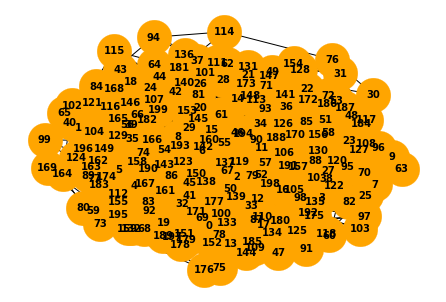

Streaming output truncated to the last 5000 lines.
{'id': 13, 'currentNode': 121, 'passArrived': 31, 'destNodes': [], 'passengers': 0, 'distTraveled': 98}
{'id': 14, 'currentNode': 193, 'passArrived': 19, 'destNodes': [], 'passengers': 0, 'distTraveled': 65}
{'id': 15, 'currentNode': 148, 'passArrived': 23, 'destNodes': [], 'passengers': 0, 'distTraveled': 78}
{'id': 16, 'currentNode': 167, 'passArrived': 23, 'destNodes': [], 'passengers': 0, 'distTraveled': 79}
{'id': 17, 'currentNode': 127, 'passArrived': 28, 'destNodes': [], 'passengers': 0, 'distTraveled': 91}
{'id': 18, 'currentNode': 141, 'passArrived': 24, 'destNodes': [], 'passengers': 0, 'distTraveled': 88}
{'id': 19, 'currentNode': 193, 'passArrived': 18, 'destNodes': [], 'passengers': 0, 'distTraveled': 58}
{'id': 20, 'currentNode': 122, 'passArrived': 30, 'destNodes': [], 'passengers': 0, 'distTraveled': 96}
{'id': 21, 'currentNode': 80, 'passArrived': 24, 'destNodes': [], 'passengers': 0, 'distTraveled': 84}
{'id': 22, 'cu

In [ ]:
simulate()

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
